In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from gradcam import make_gradcam_heatmap, create_gradcam_visualization
from utils import train_model

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

y_train = y_train.flatten()
y_test = y_test.flatten()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

2025-12-17 16:06:53.635090: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 16:06:53.666533: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-17 16:06:54.395274: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
base_model = keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

for layer in base_model.layers[::-1]:
    if 'conv' in layer.name or 'activation' in layer.name:
        last_conv_layer_name = layer.name
        break

print(f"Using layer: {last_conv_layer_name}")

I0000 00:00:1765984016.933219 1163327 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2131 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Using layer: top_activation


In [ ]:
X_train_resized = np.array([keras.preprocessing.image.smart_resize(img, (224, 224)) for img in X_train[:5000]])
X_test_resized = np.array([keras.preprocessing.image.smart_resize(img, (224, 224)) for img in X_test[:1000]])

X_train_preprocessed = keras.applications.efficientnet_v2.preprocess_input(X_train_resized)
X_test_preprocessed = keras.applications.efficientnet_v2.preprocess_input(X_test_resized)

model, history = train_model(
    model, 
    X_train_preprocessed, 
    y_train[:5000],
    model_name='cifar10_efficientnet',
    epochs=10,
    early_stopping=False
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
True: cat
Predicted: cat (0.9755)


/Users/philippgeppner/LectureNotes/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_622']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


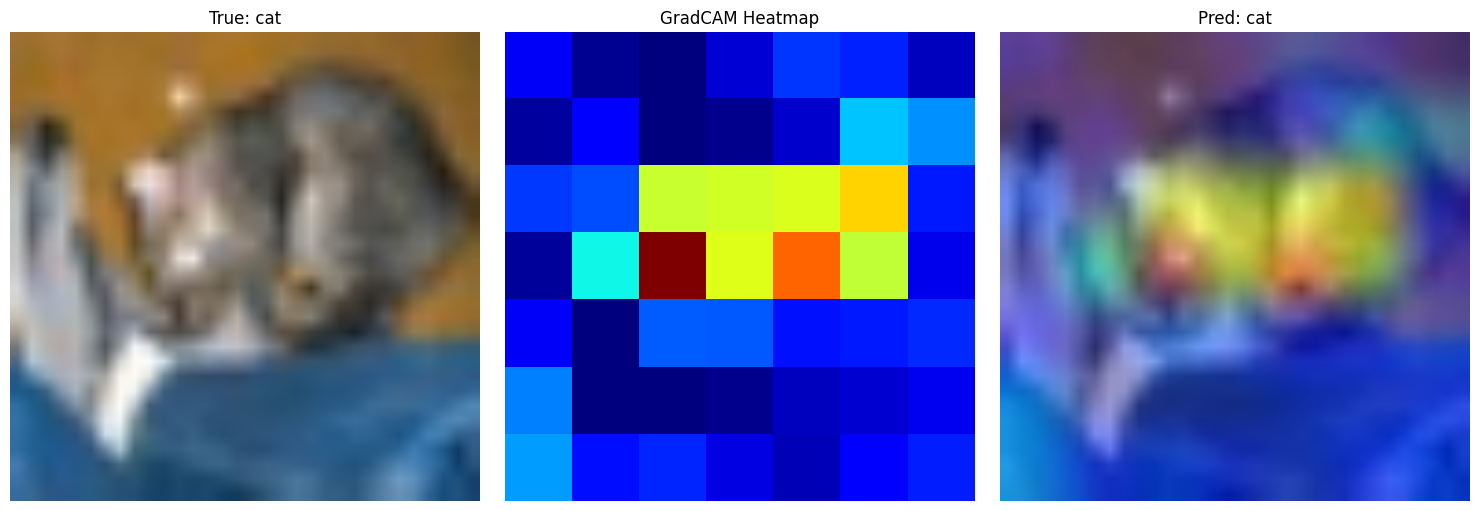

In [ ]:
img_idx = 0
img_original = X_test[img_idx]
img = X_test_resized[img_idx]
img_preprocessed = X_test_preprocessed[img_idx]
true_label = y_test[img_idx]

img_array = np.expand_dims(img_preprocessed, axis=0)
preds = model.predict(img_array)
pred_label = np.argmax(preds[0])

print(f"True: {class_names[true_label]}")
print(f"Predicted: {class_names[pred_label]} ({preds[0][pred_label]:.4f})")

heatmap = make_gradcam_heatmap(img_array, model, base_model, last_conv_layer_name)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img.astype('uint8'))
axes[0].set_title(f"True: {class_names[true_label]}")
axes[0].axis('off')

axes[1].imshow(heatmap, cmap='jet')
axes[1].set_title("GradCAM Heatmap")
axes[1].axis('off')

superimposed = create_gradcam_visualization(img, heatmap)
axes[2].imshow(superimposed)
axes[2].set_title(f"Pred: {class_names[pred_label]}")
axes[2].axis('off')

plt.tight_layout()
plt.show()

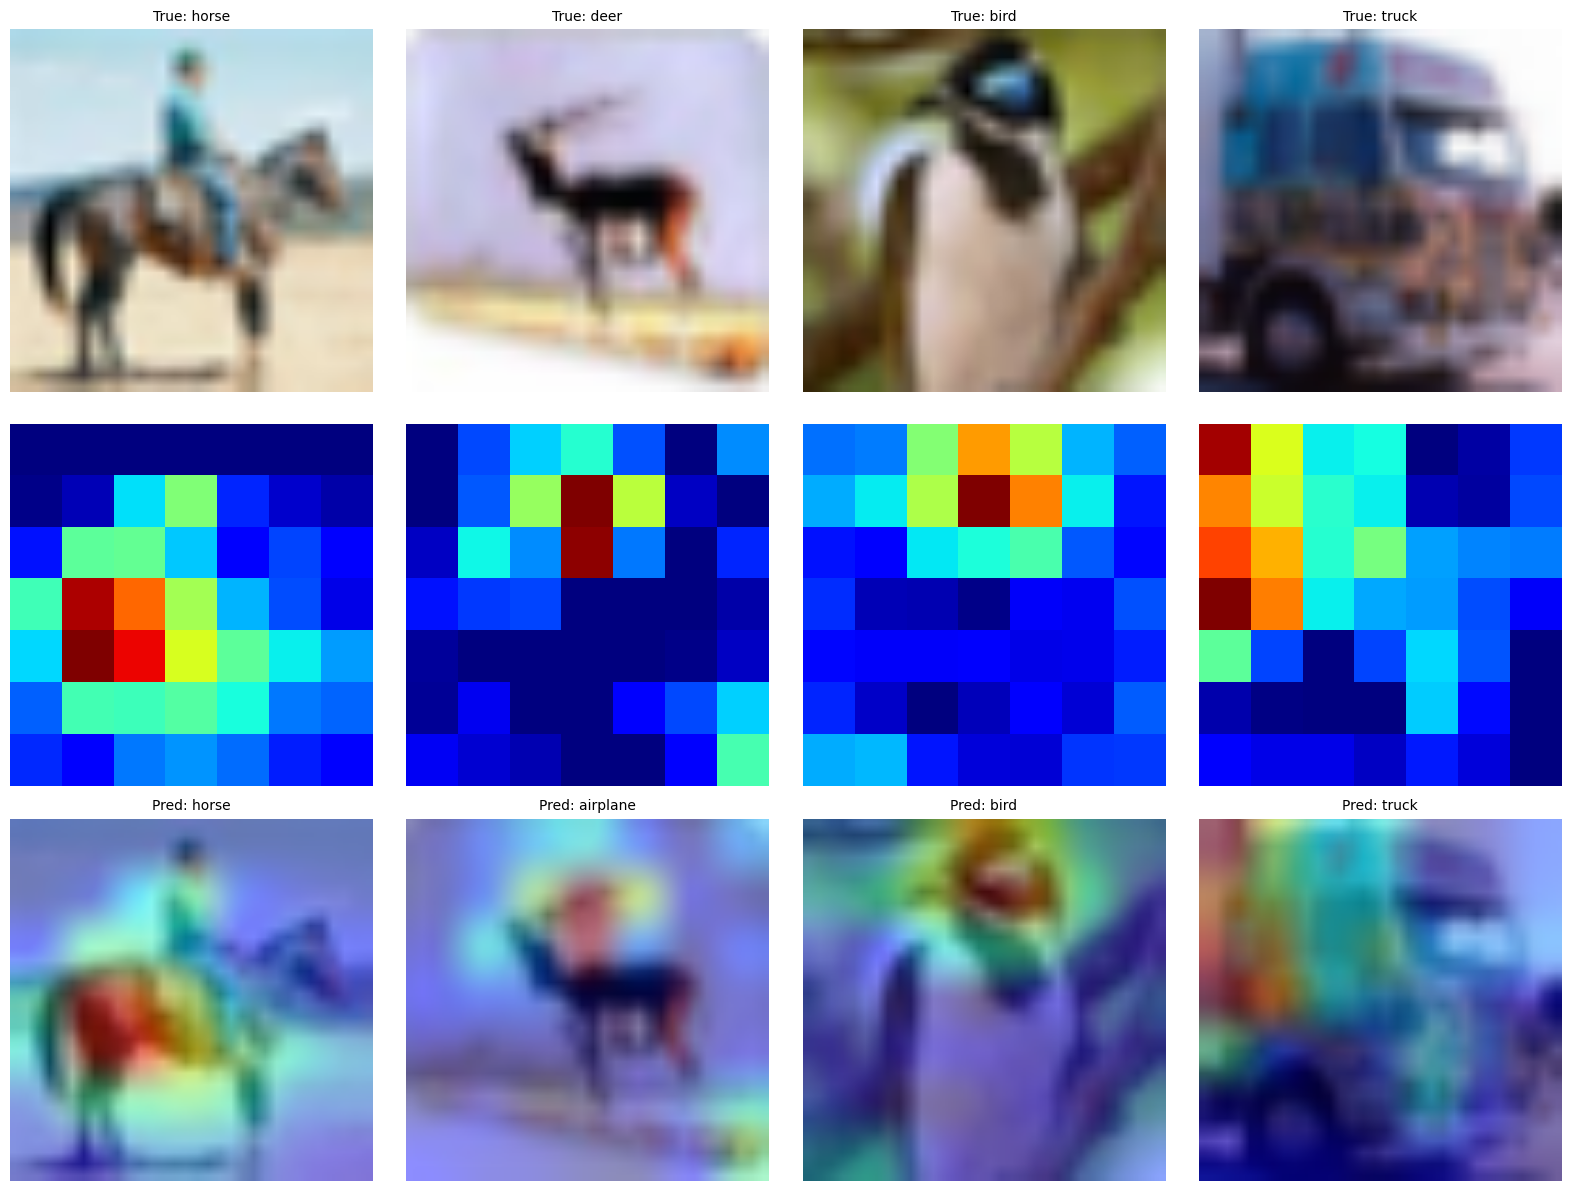

In [ ]:
np.random.seed(42)
indices = np.random.choice(len(X_test_resized), 4, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for col, idx in enumerate(indices):
    img = X_test_resized[idx]
    img_preprocessed = X_test_preprocessed[idx]
    true_label = y_test[idx]
    
    img_array = np.expand_dims(img_preprocessed, axis=0)
    preds = model.predict(img_array, verbose=0)
    pred_label = np.argmax(preds[0])
    
    heatmap = make_gradcam_heatmap(img_array, model, base_model, last_conv_layer_name)
    superimposed = create_gradcam_visualization(img, heatmap)
    
    axes[0, col].imshow(img.astype('uint8'))
    axes[0, col].set_title(f"True: {class_names[true_label]}", fontsize=10)
    axes[0, col].axis('off')
    
    axes[1, col].imshow(heatmap, cmap='jet')
    axes[1, col].axis('off')
    
    axes[2, col].imshow(superimposed)
    axes[2, col].set_title(f"Pred: {class_names[pred_label]}", fontsize=10)
    axes[2, col].axis('off')

plt.tight_layout()
plt.show()